Import all necessary libraries and install everything you need for training:

In [1]:
# install the libraries necessary for data wrangling, prediction and result analysis
import json
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
import torch
from numba import cuda
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

In [2]:
# Install transformers
# (this needs to be done on Kaggle each time you start the session)
#!pip install -q transformers

In [3]:
# Install the simpletransformers
#!pip install -q simpletransformers
from simpletransformers.classification import ClassificationModel

In [4]:
# Install wandb
#!pip install -q wandb

In [5]:
import wandb

In [6]:
# Login to wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tajak (use `wandb login --relogin` to force relogin)


True

In [7]:
# Clean the GPU cache

cuda.select_device(0)
cuda.close()
cuda.select_device(0)
torch.cuda.empty_cache()


### Import the data

In [8]:
# FTD
train_df = pd.read_csv("data/FTD-train.txt", sep="\t", index_col=0)
dev_df = pd.read_csv("data/FTD-dev.txt", sep = "\t", index_col = 0)
test_df = pd.read_csv("data/FTD-test.txt", sep = "\t", index_col = 0)

print("FTD train shape: {}, Dev shape: {}, Test shape: {}.".format(train_df.shape, dev_df.shape, test_df.shape))

FTD train shape: (849, 2), Dev shape: (283, 2), Test shape: (283, 2).


In [9]:
train_df.head()

,text,labels
1361,Business continuity plans must address massive...,7
1605,"( INDIANAPOLIS – APRIL 16 , 2010 ) – Ash conti...",8
733,Leek Friends of Israel welcome you to their we...,0
495,Npower announces further price increase Energy...,8
1534,"These businesses often had data , broad direct...",0


## Testing

We will use the multilingual XLM-RoBERTa model
https://huggingface.co/xlm-roberta-base

In [10]:
# Create a file to save results into (you can find it under Data: Output). Be careful, run this step only once to not overwrite the results file.
results = []

with open("results/FTD-Experiments-Results.json", "w") as results_file:
    json.dump(results,results_file, indent= "")

In [11]:
# Open the main results file:

previous_results_file = open("results/FTD-Experiments-Results.json")
previous_results = json.load(previous_results_file)
len(previous_results)

0

In [12]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [13]:
# Create a list of labels
LABELS = train_df.labels.unique().tolist()
LABELS

[7, 8, 0, 1, 6, 5, 2, 4, 3, 9]

In [16]:
# Initialize Wandb
run = wandb.init(project="FTD-learning-manual-hyperparameter-search", entity="tajak", name="testing-trained-model")

In [17]:
# Load the trained model from Wandb
model_name = "FTD-classifier"
# Use the latest version of the model
model_at = run.use_artifact(model_name + ":latest")
# Download the directory
model_dir = model_at.download()

# Loading a local save
model = ClassificationModel(
    "xlmroberta", model_dir)

wandb: Downloading large artifact FTD-classifier:latest, 1081.90MB. 8 files... Done. 0:0:0
/home/tajak/anaconda3/lib/python3.9/site-packages/simpletransformers/classification/classification_model.py:459: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(


In [21]:
# See the model's arguments
arg_values = []
 
pd.set_option('display.max_rows', 100)
 
# For all of the arguments...
for arg in dir(model.args):
    
    # Skip over the special attributes and any functions.
    if (not arg[0:2] == '__') and (not callable(getattr(model.args, arg))):
    
        # Store the argument and its value as a tuple.
        arg_values.append((arg, str(getattr(model.args, arg))))
 
# Store as a dataframe just to get the pretty printout.
df_args = pd.DataFrame(arg_values)        
 
df_args


,0,1
0,adafactor_beta1,None
1,adafactor_clip_threshold,1.0
2,adafactor_decay_rate,-0.8
3,adafactor_eps,"[1e-30, 0.001]"
4,adafactor_relative_step,True
5,adafactor_scale_parameter,True
6,adafactor_warmup_init,True
7,adam_epsilon,1e-08
8,best_model_dir,outputs/best_model
9,cache_dir,cache_dir/


In [20]:
# Update the args
model = ClassificationModel(
    "xlmroberta", model_dir, args= {"silent":True})

/home/tajak/anaconda3/lib/python3.9/site-packages/simpletransformers/classification/classification_model.py:459: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(


In [25]:
def testing(test_df, test_name):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in a list of results.

    Args:
    - test_df (pandas DataFrame)
    - test_name
    """
    # Get the true labels
    y_true = test_df.labels

    # Calculate the model's predictions on test
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = test_df.text.apply(make_prediction)

    # Calculate the scores
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    plt.title(f"{test_name}")

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f"results/Confusion-matrix-{test_name}.png",dpi=100)

    # Save the results:
    rezdict = {
        "experiment": test_name,
        "num_train_epochs": 10,
        "train_batch_size":8,
        "learning_rate": 1e-5,
        "microF1": micro,
        "macroF1": macro,
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist(),
        }
    previous_results.append(rezdict)

    #Save intermediate results (just in case)
    backup = []
    backup.append(rezdict)
    with open(f"backup-results-{test_name}.json", "w") as backup_file:
        json.dump(backup,backup_file, indent= "")

Macro f1: 0.759, Micro f1: 0.749


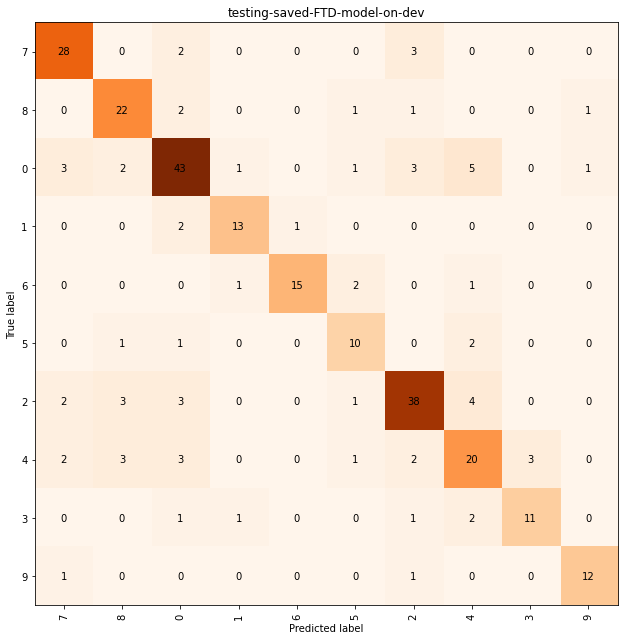

Testing finished.


<Figure size 432x288 with 0 Axes>

In [24]:
testing(dev_df, "testing-saved-FTD-model-on-dev")

print("\nTesting finished.")

Macro f1: 0.74, Micro f1: 0.739


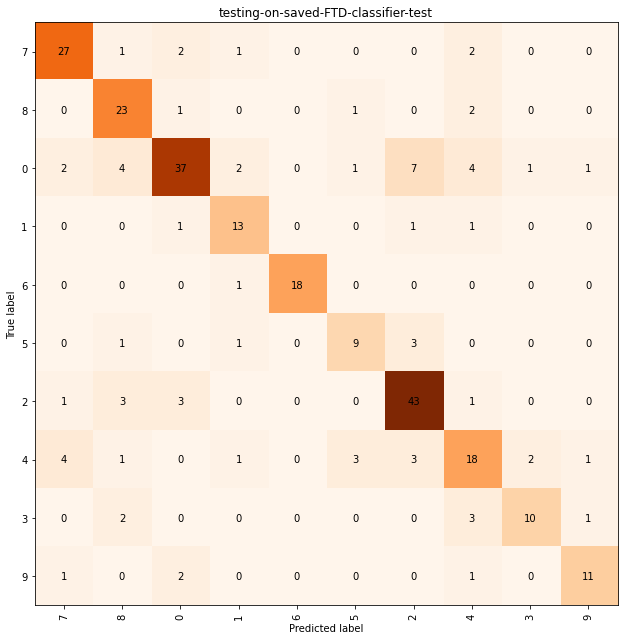


Testing finished.


<Figure size 432x288 with 0 Axes>

In [26]:
testing(test_df, "testing-on-saved-FTD-classifier-test")
print("\nTesting finished.")

In [27]:
# Compare the results by creating a dataframe from the previous_results dictionary:
results_df = pd.DataFrame(previous_results)

results_df

,experiment,num_train_epochs,train_batch_size,learning_rate,microF1,macroF1,y_true,y_pred
0,testing-saved-FTD-model-on-dev,10,8,0.00001,0.749117,0.758662,"[2, 4, 0, 2, 4, 0, 3, 2, 7, 0, 2, 6, 9, 8, 4, ...","[0, 4, 0, 2, 3, 0, 3, 2, 7, 4, 2, 5, 9, 8, 4, ..."
1,testing-on-saved-FTD-classifier-test,10,8,0.00001,0.738516,0.739792,"[6, 2, 8, 7, 3, 2, 6, 8, 5, 8, 1, 7, 7, 2, 8, ...","[6, 7, 8, 7, 3, 0, 6, 8, 5, 8, 1, 7, 4, 2, 8, ..."


In [29]:
# Save the file with updated results.
with open("results/FTD-Experiments-Results.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

In [30]:
# Clean the GPU cache
cuda.select_device(0)
cuda.close()
cuda.select_device(0)
torch.cuda.empty_cache()

RuntimeError: CUDA error: invalid argument
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.